<font color='red'>**Ciclo 3**</font>

**ENTENDER O PROBLEMA**

- Objetivo do Problema:
    - Previsão do primeiro destino que um novo usuario ira escolher.
    
    - Porque?
        - Qual o tipo de modelo de negocio do Airbnb?
        
            - Marketplace ( Conecta pessoas que oferecem acomodação, com pessoas que estão procurando acomodação )
            - Oferta ( pessoas oferecendo acomodação )
                - Tamanho do portfólio.
                - Diversidade/Densidade de Portifolio.
                - Preco Medio
                
            - Demanda ( pessoas procurando acomodação )
                - Numero de usuario
                - LTV ( Lifetime Value )
                - CAC ( Client Acquisition Cost )
                
                <font color='red'>**Receita Bruta**</font> =  ( Taxa*NúmeroDeClientes ) - CAC

             
             
- Proposta de Solução
    - Modelo de Previsão do primeiro destino de um novo usuario.
        - Predicoes e salva em uma tabela do banco de dados.
        - API
            - Input: Usuario e suas caracteristicas.
            - Output: Usuario e suas caracteristicas com a **predicao de destino** 
            

- Total de Ciclos ( CRISPM ):
    - 16 ciclos.
    

# IMPORTS

In [26]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import model_selection as ms
from sklearn import preprocessing as pp
from sklearn import metrics as m
from keras import models as ml
from keras import layers as l
from scikitplot import metrics as mt
from scipy import stats as ss


from IPython.display       import Image
from IPython.core.display  import HTML

import random

import warnings
warnings.filterwarnings('ignore')

## Helper Functions

In [3]:
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )



def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## Loading Data

In [4]:
df_raw = pd.read_csv('./data/training_users.csv', low_memory=True)
df_raw.shape

(213451, 16)

In [5]:
df_sessions = pd.read_csv('./data/sessions.csv', low_memory=True)
df_sessions.shape

#df_sessions[df_sessions['user_id'] == "00023iyk9l"][['user_id', 'action']].groupby('user_id').value_counts()

(10567737, 6)

# DATA DESCRIPTION

In [33]:
df1 = df_raw

## Data Dimensions 

In [34]:
print(f'number of rows: {df1.shape[0]}')
print(f'number of columns: {df1.shape[1]}')

number of rows: 213451
number of columns: 16


In [35]:
print(f'number of rows: {df_sessions.shape[0]}')
print(f'number of columns: {df_sessions.shape[1]}')

number of rows: 9213930
number of columns: 6


## Data Types

In [36]:
df1.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

In [37]:
df_sessions.dtypes

user_id           object
action            object
action_type       object
action_detail     object
device_type       object
secs_elapsed     float64
dtype: object

## NA Check

In [38]:
df1.isna().sum() / len(df1)

id                         0.000000
date_account_created       0.000000
timestamp_first_active     0.000000
date_first_booking         0.000000
gender                     0.000000
age                        0.000000
signup_method              0.000000
signup_flow                0.000000
language                   0.000000
affiliate_channel          0.000000
affiliate_provider         0.000000
first_affiliate_tracked    0.028414
signup_app                 0.000000
first_device_type          0.000000
first_browser              0.000000
country_destination        0.000000
dtype: float64

In [39]:
df_sessions.isna().sum() / len(df_sessions)

user_id          0.0
action           0.0
action_type      0.0
action_detail    0.0
device_type      0.0
secs_elapsed     0.0
dtype: float64

In [40]:
# df1 = df1.dropna()
# df1.shape

# ================ Users ====================

# date_first_booking
date_first_booking_max = pd.to_datetime(df1['date_first_booking']).max().strftime('%Y-%m-%d')
df1['date_first_booking'] = df1['date_first_booking'].fillna(date_first_booking_max)

# age
avg_age = age = df1['age'].mean().astype(int)
df1['age'] = df1['age'].fillna(avg_age)

# first_affiliate_tracked
df1 = df1[~df1['first_affiliate_tracked'].isna()]

# ================ Sessions ====================

# user_id - 0.3%
df_sessions = df_sessions[~df_sessions['user_id'].isna()]


# action - 0.7%
df_sessions = df_sessions[~df_sessions['action'].isna()]


# action_type - 11%
df_sessions = df_sessions[~df_sessions['action_type'].isna()]


# action_detail - 11%
df_sessions = df_sessions[~df_sessions['action_detail'].isna()]


# secs_elapsed - 1.2%
df_sessions = df_sessions[~df_sessions['secs_elapsed'].isna()]


## Change Data Type

In [41]:
# date_account_created
df1['date_account_created'] = pd.to_datetime(df1['date_account_created'])

# timestamp_first_active
df1['timestamp_first_active'] = pd.to_datetime(df1['timestamp_first_active'], format='%Y%m%d%H%M%S')

# date_first_booking
df1['date_first_booking'] = pd.to_datetime(df1['date_first_booking'])

# age
df1['age'] = df1['age'].astype(int)

In [42]:
df1.dtypes

id                                 object
date_account_created       datetime64[ns]
timestamp_first_active     datetime64[ns]
date_first_booking         datetime64[ns]
gender                             object
age                                 int64
signup_method                      object
signup_flow                         int64
language                           object
affiliate_channel                  object
affiliate_provider                 object
first_affiliate_tracked            object
signup_app                         object
first_device_type                  object
first_browser                      object
country_destination                object
dtype: object

## Check Balanced Data

In [43]:
df1['country_destination'].value_counts(normalize=True)

NDF      0.579673
US       0.294461
other    0.048128
FR       0.023623
IT       0.013458
GB       0.011066
ES       0.010671
CA       0.006707
DE       0.005020
NL       0.003621
AU       0.002541
PT       0.001032
Name: country_destination, dtype: float64

# DATA FILTERING

In [44]:
df2 = df1.copy()

## Filtering Rows

## Columns Selection

# DATA PREPARATION

In [45]:
df3 = df2.copy()

In [46]:
# dummy variable
df3_dummy = pd.get_dummies(df3.drop(['id', 'country_destination'], axis=1))

# join id and country_destination
df3 = pd.concat([df3[['id', 'country_destination']], df3_dummy], axis=1)

# FEATURE SELECTION

In [47]:
cols_drop = ['date_account_created', 'timestamp_first_active'] # origial dates
df4 = df3.drop( cols_drop, axis=1)

In [48]:
X = df4.drop('country_destination', axis=1)
y = df4['country_destination'].copy()

In [49]:
# split dataset into training and test
X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state=32)

# MACHINE LEARNING MODEL

In [50]:
x_train = X_train.drop('id', axis=1)
x_test = X_test.drop('id', axis=1)

## Baseline Model

In [51]:
country_destination_list = df1['country_destination'].drop_duplicates().sort_values().tolist()
k_num = y_test.shape[0]
country_destination__weights = df1['country_destination'].value_counts(normalize=True).sort_index().to_list()

yhat_random = random.choices(population=country_destination_list, 
                               weights=country_destination__weights,
                               k=k_num)
len(yhat_random)

41478

Accuracy: 0.4228265586576016
Balanced Accuracy: 0.08262195114114197
Kappa Score: -0.00486834304992767
              precision    recall  f1-score   support

          AU       0.00      0.00      0.00       111
          CA       0.01      0.01      0.01       281
          DE       0.00      0.00      0.00       215
          ES       0.01      0.01      0.01       428
          FR       0.02      0.02      0.02      1021
          GB       0.01      0.01      0.01       426
          IT       0.02      0.02      0.02       570
         NDF       0.58      0.58      0.58     23996
          NL       0.00      0.00      0.00       146
          PT       0.00      0.00      0.00        48
          US       0.29      0.29      0.29     12280
       other       0.05      0.05      0.05      1956

    accuracy                           0.42     41478
   macro avg       0.08      0.08      0.08     41478
weighted avg       0.42      0.42      0.42     41478



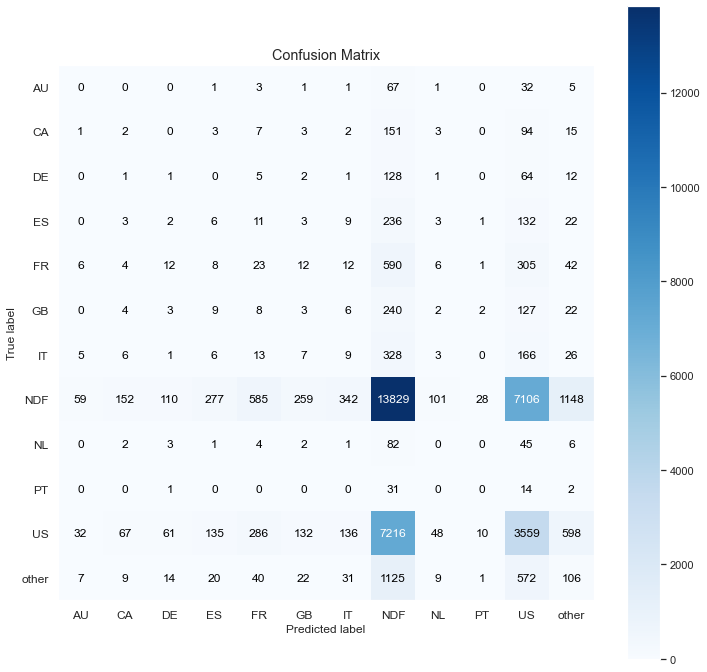

In [52]:
# Accuracy
acc_random = m.accuracy_score(y_test, yhat_random)
print(f'Accuracy: {acc_random}')

# Balanced Accuracy
balanced_acc_random = m.balanced_accuracy_score(y_test, yhat_random)
print(f'Balanced Accuracy: {balanced_acc_random}')

# Kappa Metrics
kappa_random = m.cohen_kappa_score(y_test, yhat_random)
print(f'Kappa Score: {kappa_random}')

# Classification Report 
print(m.classification_report(y_test, yhat_random))

# Confusion Matrix
mt.plot_confusion_matrix(y_test, yhat_random, normalize=False, figsize=(12,12));

## Neural Network - MLP

In [53]:
ohe = pp.OneHotEncoder()
y_train_nn = ohe.fit_transform(y_train.values.reshape(-1, 1)).toarray()

In [54]:
x_train.shape

(165908, 133)

In [55]:
# model definition
model = ml.Sequential()
model.add(l.Dense(128, input_dim=x_train.shape[1], activation='relu'))
model.add(l.Dense(11, activation='softmax'))

# model compile
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# train mode
model.fit(x_train, y_train_nn, epochs=100)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type Timestamp).

## NEURAL NETWORK PERFORMANCE

In [106]:
# prediction
pred_nn = model.predict(x_test)

# invert prediction
yhat_nn = ohe.inverse_transform(pred_nn)

# prediction prepare
y_test_nn = y_test.to_numpy()
yhat_nn = yhat_nn.reshape(1, -1)[0]

1297/1297 [==============================] - 2s 1ms/step


In [107]:
# Balanced Accuracy
m.balanced_accuracy_score(y_test_nn, yhat_nn)

0.16666666666666666

Accuracy: 0.8745841168812383
Balanced Accuracy: 0.16666666666666666
Kappa Score: 0.7679722856853507
              precision    recall  f1-score   support

          AU       0.00      0.00      0.00       111
          CA       0.00      0.00      0.00       281
          DE       0.00      0.00      0.00       215
          ES       0.00      0.00      0.00       428
          FR       0.00      0.00      0.00      1021
          GB       0.00      0.00      0.00       426
          IT       0.00      0.00      0.00       570
         NDF       1.00      1.00      1.00     23996
          NL       0.00      0.00      0.00       146
          PT       0.00      0.00      0.00        48
          US       0.70      1.00      0.83     12280
       other       0.00      0.00      0.00      1956

    accuracy                           0.87     41478
   macro avg       0.14      0.17      0.15     41478
weighted avg       0.79      0.87      0.82     41478



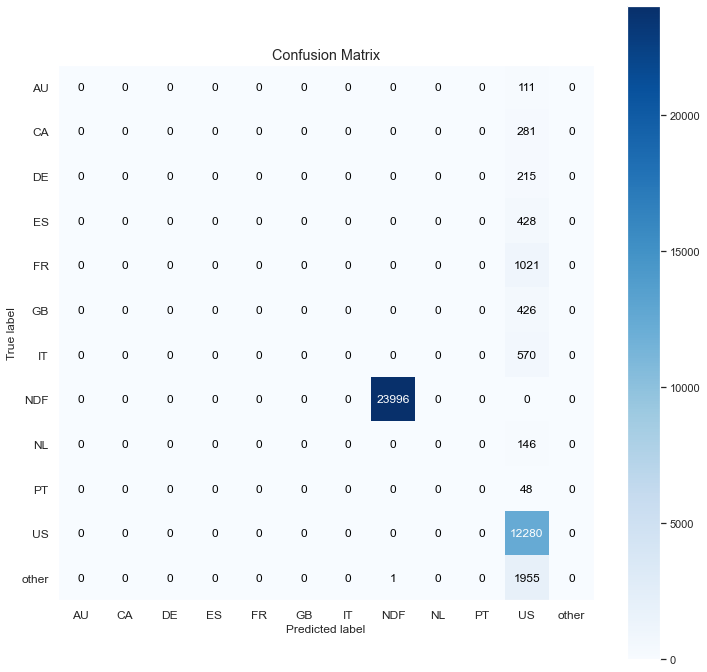

In [108]:
# Accuracy
acc_nn = m.accuracy_score(y_test_nn, yhat_nn)
print(f'Accuracy: {acc_nn}')

# Balanced Accuracy
balanced_acc_nn = m.balanced_accuracy_score(y_test_nn, yhat_nn)
print(f'Balanced Accuracy: {balanced_acc_nn}')

# Kappa Metrics
kappa_nn = m.cohen_kappa_score(y_test_nn, yhat_nn)
print(f'Kappa Score: {kappa_nn}')

# Classification Report 
print(m.classification_report(y_test_nn, yhat_nn))

# Confusion Matrix
mt.plot_confusion_matrix(y_test_nn, yhat_nn, normalize=False, figsize=(12,12));

### NEURAL NETWORK PERFORMANCE - Cross-Validation

In [50]:
# generate k-fold
num_folds = 5
kfold = ms.StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=32)

# create list

balanced_acc_list = []
kappa_acc_list = []

i = 1
for train_ix, val_ix in kfold.split(x_train, y_train):
    
    print(f'Folder Number: {i} / {num_folds}')
    
    # get fold
    x_train_fold = x_train.iloc[train_ix]
    y_train_fold = y_train.iloc[train_ix]
    
    x_val_fold = x_train.iloc[val_ix]
    y_val_fold = y_train.iloc[val_ix]
    

    # target - hot-enconding
    ohe = pp.OneHotEncoder()
    y_train_fold_nn = ohe.fit_transform(y_train_fold.values.reshape(-1, 1)).toarray()
    
    # model definition
    model = ml.Sequential()
    model.add(l.Dense(256, input_dim=x_train.shape[1], activation='relu'))
    model.add(l.Dense(11, activation='softmax'))

    # compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # training model
    model.fit(x_train_fold, y_train_fold_nn, epochs=100, batch_size=32, verbose=0)

    # prediction
    pred_nn = model.predict(x_val_fold) #dados encoding
    yhat_nn = ohe.inverse_transform(pred_nn) # dados original
    
    # prepare data
    y_test_nn = y_val_fold.to_numpy()
    yhat_nn = yhat_nn.reshape(1, -1)[0]
    
    # metrics
    
    ## balanced accuracy
    balanced_acc_nn = m.balanced_accuracy_score(y_test_nn, yhat_nn)
    balanced_acc_list.append(balanced_acc_nn)
    
    ## kappa metrics
    kappa_acc_nn = m.cohen_kappa_score(y_test_nn, yhat_nn)
    kappa_acc_list.append(kappa_acc_nn)
    
    i += 1

Folder Number: 1 / 5
341/341 [==============================] - 0s 1ms/step
Folder Number: 2 / 5
341/341 [==============================] - 0s 1ms/step
Folder Number: 3 / 5
341/341 [==============================] - 0s 1ms/step
Folder Number: 4 / 5
341/341 [==============================] - 0s 1ms/step
Folder Number: 5 / 5
341/341 [==============================] - 0s 1ms/step


In [51]:
print(f'Avg Balanced Accuracy: {np.mean(balanced_acc_list)} / {np.std(balanced_acc_list)}')
print(f'Avg Kapaa: {np.mean(kappa_acc_list)} / {np.std(kappa_acc_list)}')

Avg Balanced Accuracy: 0.09145240775117988 / 0.00024304742342277685
Avg Kapaa: 0.002443131827766032 / 0.0017743233095031017
